In [1]:
from pytorch3d import io
import torch
from pytorch3d.renderer.cameras import FoVPerspectiveCameras, PerspectiveCameras
from pytorch3d.renderer.points.rasterizer import PointsRasterizer, PointsRasterizationSettings
from pytorch3d.structures import Pointclouds
from pytorch3d.utils import cameras_from_opencv_projection 

from scene.dataset_readers import readColmapSceneInfo
from utils.camera_utils import loadCam
from collections import namedtuple
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import mrob
from tqdm import tqdm
from joblib import Parallel, delayed

from pytorch3d.renderer import (
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    NormWeightedCompositor
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
ply_path = "/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/scenes/office_4/office_4_base/sparse/0/points3D.ply"

pcd_o3d = o3d.io.read_point_cloud(ply_path)
pcd_o3d = pcd_o3d.voxel_down_sample(voxel_size=0.025)
points_tensor = torch.tensor(np.asarray(pcd_o3d.points)).unsqueeze(0).cuda().float()
colors_tensor = torch.tensor(np.asarray(pcd_o3d.colors)).unsqueeze(0).cuda().float()
points = Pointclouds(points_tensor, features=colors_tensor)

In [9]:
scene_info = readColmapSceneInfo('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/scenes/office_4/office_4_task', 'images', eval=False)

Reading camera 32/32


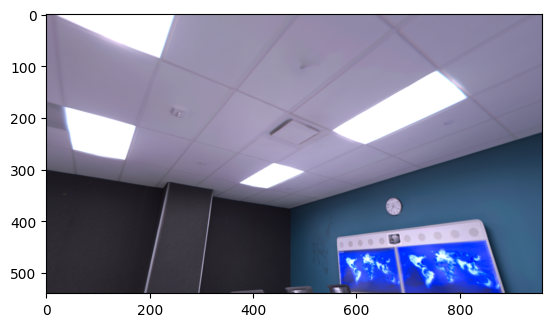

In [10]:
args = namedtuple('args', ['resolution', 'data_device'])
args = args(2, 'cuda:1')
pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
pipe = pipe(False, False, False)
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

id = 10
camera = loadCam(args=args, id = id, cam_info=scene_info.train_cameras[id], resolution_scale=1)
plt.imshow(camera.original_image.cpu().numpy().transpose(1,2,0))

In [11]:
height = camera.image_height
width = camera.image_width

fx = camera.fx
fy = camera.fy

cx = camera.cx
cy = camera.cy

T_gt = mrob.geometry.SE3(mrob.geometry.SO3(camera.R), camera.T)

camera_matrix = torch.tensor([[fx, 0, cx],
                               [0, fy, cy],
                               [0,0,1]])
# R = [camera.R for camera in cameras]
# tvec = [camera.T for camera in cameras]

camera_p3d = cameras_from_opencv_projection(R = torch.tensor(np.array(T_gt.R())).unsqueeze(0).float(), 
                                            tvec = torch.tensor(np.array(T_gt.t())).unsqueeze(0).float(), 
                                            camera_matrix = camera_matrix.unsqueeze(0).float(),
                                            image_size = torch.tensor([height, 
                                                                        width]).unsqueeze(0).float())

raster_settings = PointsRasterizationSettings(
                image_size=(height, 
                            width), 
                radius = 0.025,
                points_per_pixel = 1
                )

rasterizer = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)

rendered = rasterizer(points)

renderer = PointsRenderer(
    rasterizer=rasterizer,
    # Pass in background_color to the alpha compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
    compositor=NormWeightedCompositor()
)

images = renderer(points)

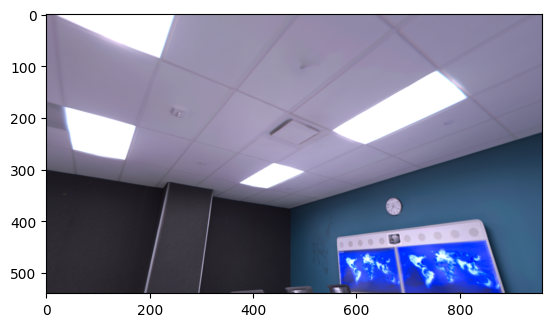

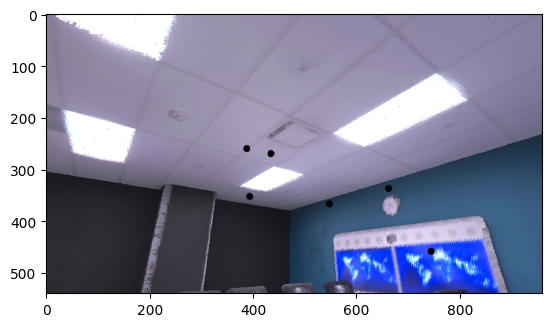

In [12]:
plt.imshow(camera.original_image.cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(images[0].cpu().numpy())
plt.show()

In [13]:
def compute_3diou(R, tvec, fx, fy, cx, cy, height, width, points):
    camera_matrix = torch.tensor([[fx, 0, cx],
                               [0, fy, cy],
                               [0,0,1]])
    # R = [camera.R for camera in cameras]
    # tvec = [camera.T for camera in cameras]

    cameras_p3d = cameras_from_opencv_projection(R = torch.tensor(np.array(R)).float(), tvec = torch.tensor(np.array(tvec)).float(), 
                                               camera_matrix = camera_matrix.unsqueeze(0).repeat(2,1,1).float(),
                                               image_size = torch.tensor([height, 
                                                                          width]).unsqueeze(0).repeat(2,1).float())
    
    raster_settings = PointsRasterizationSettings(
                    image_size=(height, 
                                width), 
                    radius = 0.025,
                    points_per_pixel = 1 
                    )
    rendered = PointsRasterizer(cameras=cameras_p3d[0].cuda(), raster_settings=raster_settings)(points)
    # return rendered
    # Create a points rasterizer
    sets = [set(torch.unique(PointsRasterizer(cameras=camera, raster_settings=raster_settings)(points).idx)[1:].tolist()) for camera in cameras_p3d.cuda()]

    intersection_indices = sets[1].intersection(sets[0])
    union_indices = sets[1].union(sets[0])
    iou = len(intersection_indices)/len(union_indices)

    return iou, list(intersection_indices), list(union_indices), [list(set_) for set_ in sets]

In [19]:
def compute_point_cloud_camera_fraction(R, tvec, fx, fy, cx, cy, height, width, points):
    camera_matrix = torch.tensor([[fx, 0, cx],
                               [0, fy, cy],
                               [0,0,1]])
    # R = [camera.R for camera in cameras]
    # tvec = [camera.T for camera in cameras]

    camera_p3d = cameras_from_opencv_projection(R = torch.tensor(np.array(R)).unsqueeze(0).float(), 
                                                tvec = torch.tensor(np.array(tvec)).unsqueeze(0).float(), 
                                                camera_matrix = camera_matrix.unsqueeze(0).float(),
                                                image_size = torch.tensor([height, 
                                                                          width]).unsqueeze(0).float())
    
    raster_settings = PointsRasterizationSettings(
                    image_size=(height, 
                                width), 
                    radius = 0.025,
                    points_per_pixel = 1
                    )
    rendered = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)(points)
    rasterizer = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)

    renderer = PointsRenderer(
        rasterizer=rasterizer,
        # Pass in background_color to the alpha compositor, setting the background color 
        # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
        compositor=NormWeightedCompositor()
    )
    print(renderer)
    images = renderer(points)
    return images

    # Create a points rasterizer
    fraction_set = set(torch.unique(PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)(points).idx)[1:].tolist())

    return fraction_set

In [20]:
height = camera.image_height
width = camera.image_width

fx = camera.fx
fy = camera.fy

cx = camera.cx
cy = camera.cy

T_gt = mrob.geometry.SE3(mrob.geometry.SO3(camera.R), camera.T)

camera_matrix = torch.tensor([[fx, 0, cx],
                               [0, fy, cy],
                               [0,0,1]])
# R = [camera.R for camera in cameras]
# tvec = [camera.T for camera in cameras]

camera_p3d = cameras_from_opencv_projection(R = torch.tensor(np.array(T_gt.R())).unsqueeze(0).float(), 
                                            tvec = torch.tensor(np.array(T_gt.t())).unsqueeze(0).float(), 
                                            camera_matrix = camera_matrix.unsqueeze(0).float(),
                                            image_size = torch.tensor([height, 
                                                                        width]).unsqueeze(0).float())

raster_settings = PointsRasterizationSettings(
                image_size=(height, 
                            width), 
                radius = 0.025,
                points_per_pixel = 1
                )
rendered = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)(points)
rasterizer = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)

renderer = PointsRenderer(
    rasterizer=rasterizer,
    # Pass in background_color to the alpha compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
    compositor=NormWeightedCompositor()
)
print(renderer)
images = renderer(points)

PointsRenderer(
  (rasterizer): PointsRasterizer(
    (cameras): PerspectiveCameras()
  )
  (compositor): NormWeightedCompositor()
)


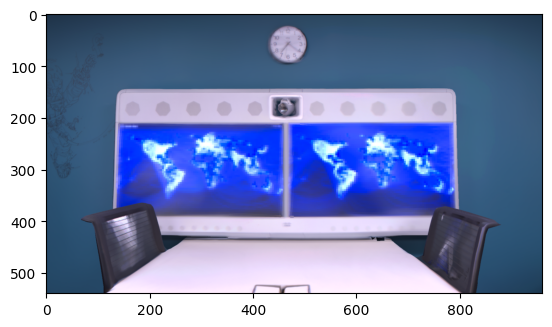

In [21]:
plt.imshow(camera.original_image.cpu().numpy().transpose(1,2,0))

In [22]:
plt.imshow(set_gt.cpu().numpy()[0])

NameError: name 'set_gt' is not defined

In [23]:
from pytorch3d.renderer import (
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    NormWeightedCompositor
)

In [24]:
def compute_iou_2sets(set0, set1):

    intersection_indices = set0.intersection(set1)
    union_indices = set0.union(set1)
    iou = len(intersection_indices)/len(union_indices)

    return iou, list(intersection_indices), list(union_indices)

In [25]:
id = 2
camera = loadCam(args=args, id = id, cam_info=scene_info.train_cameras[id], resolution_scale=1)

In [26]:
camera.image_path

AttributeError: 'CameraLie' object has no attribute 'image_path'

In [27]:
results = []


T_gt = mrob.geometry.SE3(mrob.geometry.SO3(camera.R), camera.T)
set_gt = compute_point_cloud_camera_fraction(**{'R':T_gt.R(), 'tvec':T_gt.t(), 
                        "fx":fx, 'fy':fy, 
                        'cx':cy, 'cy':cy, 
                        'height':height, 'width':width, 
                        'points':points})

for noise_level in tqdm(np.linspace(0,0.3,1000).tolist() + np.linspace(0.3,1,1000).tolist()):
    tries = 1
    for num_try in range(tries):
        perturbation = np.random.randn(6)*noise_level
        T_init = mrob.geometry.SE3(perturbation).mul(T_gt)

        set_init = compute_point_cloud_camera_fraction(**{'R':T_init.R(), 'tvec':T_init.t(), 
                        "fx":fx, 'fy':fy, 
                        'cx':cy, 'cy':cy, 
                        'height':height, 'width':width, 
                        'points':points})


        results.append(compute_iou_2sets(set_gt, set_init)[0])

PointsRenderer(
  (rasterizer): PointsRasterizer(
    (cameras): PerspectiveCameras()
  )
  (compositor): NormWeightedCompositor()
)


  0%|          | 0/2000 [00:00<?, ?it/s]

PointsRenderer(
  (rasterizer): PointsRasterizer(
    (cameras): PerspectiveCameras()
  )
  (compositor): NormWeightedCompositor()
)


AttributeError: 'Tensor' object has no attribute 'intersection'

In [48]:
results_frame = {np.round(iou_bin, 2):[] for iou_bin in np.linspace(0,1,21)}

{0.0: [],
 0.05: [],
 0.1: [],
 0.15: [],
 0.2: [],
 0.25: [],
 0.3: [],
 0.35: [],
 0.4: [],
 0.45: [],
 0.5: [],
 0.55: [],
 0.6: [],
 0.65: [],
 0.7: [],
 0.75: [],
 0.8: [],
 0.85: [],
 0.9: [],
 0.95: [],
 1.0: []}

In [49]:
T_init.T()

array([[-0.48052558,  0.85532636,  0.19368012, -0.93189191],
       [ 0.25279485,  0.34656864, -0.90331885, -1.57829623],
       [-0.83975587, -0.38510648, -0.3827572 ,  2.57860394],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [39]:
np.round(iou/0.05)*0.05

0.1

In [ ]:
# ret = Parallel(n_jobs=12)(
#     delayed(compute_3diou)(**x) for x in tqdm(task_data)
# )

In [51]:
camera.colmap_id

1

(array([188.,  19.,  22.,  23.,  16.,  20.,  17.,  14.,  20.,  13.,  14.,
         12.,  13.,  16.,  12.,  14.,  14.,  15.,  20.,  15.,  12.,  16.,
         19.,  13.,  15.,  22.,  19.,  20.,  18.,  21.,  26.,  22.,  18.,
         22.,  27.,  26.,  15.,  20.,  21.,  27.,  19.,  29.,  17.,  29.,
         40.,  24.,  31.,  28.,  27.,  25.,  26.,  38.,  29.,  25.,  21.,
         44.,  35.,  23.,  26.,  32.,  29.,  23.,  32.,  34.,  33.,  28.,
         23.,  13.,  24.,  28.,  19.,  27.,  15.,  24.,  19.,  22.,  18.,
         17.,  21.,  20.,  17.,  19.,  13.,   7.,   7.,   2.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.00999986, 0.01999972, 0.02999958, 0.03999944,
        0.0499993 , 0.05999916, 0.06999902, 0.07999888, 0.08999874,
        0.0999986 , 0.10999846, 0.11999832, 0.12999818, 0.13999804,
        0.1499979 , 0.15999776, 0.16999761, 0.17999747, 0.18999733,
        0.19999719, 0.20999705, 0.21999691, 0.

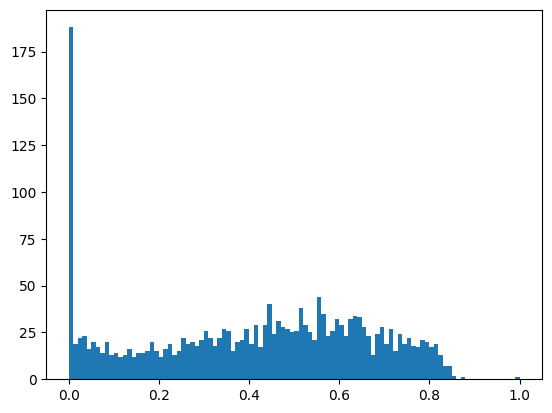

In [17]:
plt.hist(results, bins=100)

In [18]:
plt.hist(np.array(ious)[np.array(ious)>0.8], bins=100)

NameError: name 'ious' is not defined

In [ ]:
bins = np.arange(np.sort(ious)[0], np.sort(ious)[-1]+0.05, 0.05) - 1e-12

In [ ]:
bins

array([-1.0e-12,  5.0e-02,  1.0e-01,  1.5e-01,  2.0e-01,  2.5e-01,
        3.0e-01,  3.5e-01,  4.0e-01,  4.5e-01,  5.0e-01,  5.5e-01,
        6.0e-01,  6.5e-01,  7.0e-01,  7.5e-01,  8.0e-01,  8.5e-01,
        9.0e-01,  9.5e-01,  1.0e+00])

In [ ]:
(counts, _) = np.histogram(ious, bins)

In [ ]:
counts

array([1787,  525,  517,  571,  618,  588,  631,  669,  647,  671,  600,
        508,  459,  387,  343,  290,  172,    9,    5,    3])

In [ ]:
counts.cumsum()

array([ 1787,  2312,  2829,  3400,  4018,  4606,  5237,  5906,  6553,
        7224,  7824,  8332,  8791,  9178,  9521,  9811,  9983,  9992,
        9997, 10000])

In [ ]:
np.sort(ious)

array([0.        , 0.        , 0.        , ..., 0.95838943, 0.96350465,
       0.99998597])

In [ ]:
indices = intersection_indices
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(np.asarray(pcd_o3d.points)[indices])
point_cloud.colors = o3d.utility.Vector3dVector(np.asarray(pcd_o3d.colors)[indices])
point_cloud.normals = o3d.utility.Vector3dVector(np.asarray(pcd_o3d.normals)[indices])

NameError: name 'intersection_indices' is not defined

In [ ]:
o3d.io.write_point_cloud('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/office_4/office_4_task/points_cam_intersection.ply', point_cloud)

True

In [1]:
import pickle
with open('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/scenes/apartment_1/apartment_1_task/images_pairs/00000.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [29]:
b.keys()

dict_keys(['point_cloud_path', 'scene', 'img_name', 'frames'])

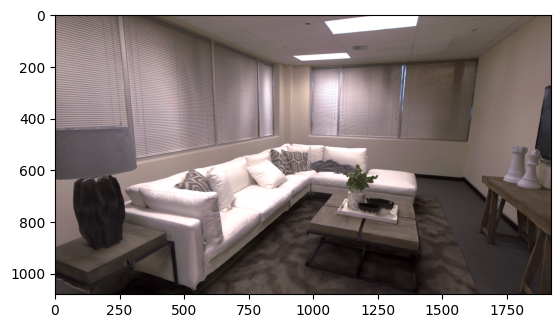

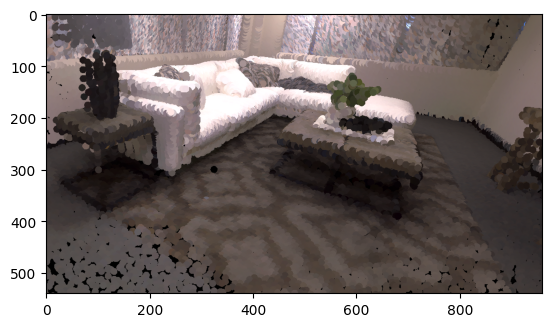

In [5]:
# print(b['frames']['init_frames_iou_bins'].keyes())
import matplotlib.pyplot as plt
plt.imshow((b['frames']['image']))
plt.show()
plt.imshow((b['frames']['init_frames_iou_bins'][0.35][0]['init_image']))

In [13]:
b['frames']['00000']['init_frames_iou_bins_stats']

{0.0: 216,
 0.05: 94,
 0.1: 75,
 0.15: 73,
 0.2: 75,
 0.25: 87,
 0.3: 108,
 0.35: 109,
 0.4: 115,
 0.45: 145,
 0.5: 147,
 0.55: 151,
 0.6: 137,
 0.65: 138,
 0.7: 114,
 0.75: 97,
 0.8: 93,
 0.85: 24,
 0.9: 1,
 0.95: 0,
 1.0: 1}

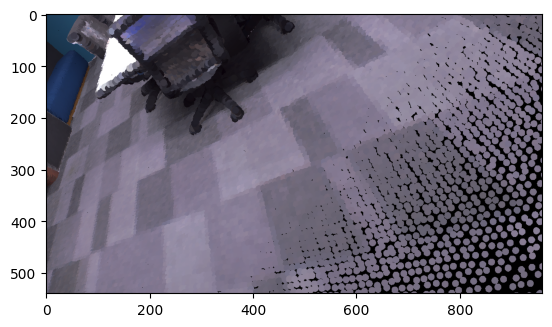

In [25]:
plt.imshow(b['frames']['00000']['init_frames_iou_bins'][0.05][35]['init_image'])

In [27]:
from glob import glob

glob('/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/*')

['/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/compute3diou_debug.ipynb',
 '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/assets',
 '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/metrics.py',
 '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/README.md',
 '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/LICENSE.md',
 '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/debug.ipynb',
 '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/grad_cheking.ipynb',
 '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/__pycache__',
 '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/scene',
 '/mnt/sdb1/home/kbotashev/mip-nerf_proje

In [ ]:
for key in b['00000']['init_frames'].keys():
    if len(b['00000']['init_frames'][key])
    b['00000']['init_frames'][key] = b['00000']['init_frames'][key][0]

In [21]:
{key:len(b['00000']['init_frames'][key]) for key in b['00000']['init_frames'].keys()}

{0.0: 216,
 0.05: 94,
 0.1: 75,
 0.15: 73,
 0.2: 75,
 0.25: 87,
 0.3: 108,
 0.35: 109,
 0.4: 115,
 0.45: 145,
 0.5: 147,
 0.55: 151,
 0.6: 137,
 0.65: 138,
 0.7: 114,
 0.75: 97,
 0.8: 93,
 0.85: 24,
 0.9: 1,
 0.95: 0,
 1.0: 1}

In [ ]:
b['point_cloud_path']

'/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/office_4/office_4_base/sparse/0/points3D.ply'